<a href="https://colab.research.google.com/github/savinthie/Final_Year_Project_IDP_2024-2025/blob/main/Final_IDP_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing of necessary libraries**

In [14]:
from tensorflow.keras.layers import Layer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, ReLU, Concatenate, MaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
from google.colab import drive

**Data collection stage**

In [15]:
drive.mount('/content/drive')
original_household_dataset = pd.read_csv('/content/drive/MyDrive/FYP 2024 25/USDataset.csv', header=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data preprocessing stage**

In [26]:
original_household_dataset = original_household_dataset.fillna(0)
original_household_dataset.columns = [col.lower().replace(' ', '').replace('.', '') for col in original_household_dataset.columns]
cols_to_keep = ['stateabv', 'county', 'family', 'housing', 'food', 'transportation',
                'healthcare', 'othernecessities', 'childcare', 'taxes', 'total',
                'median_family_income', 'num_counties_in_st']
household_dataset = original_household_dataset[cols_to_keep].copy()

household_dataset['median_family_income'] = household_dataset['median_family_income'].replace(',', '', regex=True).astype(float)

**Feature engineering stage**

In [27]:
household_dataset['median_family_income'] = household_dataset['median_family_income'].map(lambda x: x/12)#getting the median family income on monthly basis
household_dataset['n_parents'] = household_dataset['family'].str.slice(0, 1).astype(int) # new feature
household_dataset['n_children'] = household_dataset['family'].str.slice(2, 3).astype(int) # new feature
household_dataset['n_members'] = household_dataset['n_parents'] + household_dataset['n_children'] # new feature
household_dataset['financial_stability'] = household_dataset['median_family_income'] / household_dataset['total'] # new feature
household_dataset["per_member_cost"] = household_dataset["total"] / household_dataset["n_members"] # new feature
household_dataset["child_expense_cost"] = household_dataset["per_member_cost"]*household_dataset["n_children"] # new feature
household_dataset["parent_expense_cost"] = household_dataset["per_member_cost"]*household_dataset["n_parents"] # new feature
household_dataset["other_expense_cost"] = household_dataset["total"] - (household_dataset["child_expense_cost"]+household_dataset["parent_expense_cost"]) # new feature
# fixing the 0 child issue
household_dataset["zero_childcare_cost"] = household_dataset['n_children'].map(lambda x: 0 if x < 1 else 1) # new feature

**Feature scaling (An important data handling technique in the Neural networks)**

In [28]:
# Splitting the data
#inputs
X = household_dataset[['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']+['per_member_cost','child_expense_cost','parent_expense_cost','other_expense_cost','zero_childcare_cost']].values
# output labels
y_expenses = household_dataset[['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']].values
# output labels
target_col_list = ['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']

# Scaling
scaler_X = MinMaxScaler()

# Load the X scaler
# scaler_X = joblib.load('scaler_X.pkl')

X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()

# Load the y scaler
# scaler_y = joblib.load('scaler_y.pkl')
y_exp_scaled = scaler_y.fit_transform(y_expenses)


# Save the X scaler
joblib.dump(scaler_X, 'scaler_X.pkl')

# Save the y scaler
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [29]:
# this method is used to avoid the issue in the mape and smape value for the childcare expenses since the childcare expenses consist of 0 value where the smape and mape are sensitive of.
def replace_zeros_with_ones(a, b):
    # Iterate through both lists simultaneously
    for i in range(len(a)):
        # If both value is 0, replace both with 1
        if a[i] == 0 and b[i] == 0:
            a[i] = 1
            b[i] = 1
    return a, b

*The replace_zero_with_one function is used to handle the infinity values in the MAPE and SMAPE metrics in the Childcare expenses since the Childcare expense for the no child is 0*

In [30]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculateSmape(y_true, y_pred):
    y_true, y_pred = replace_zeros_with_ones(y_true, y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [42]:
# Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=100) # 5 folds

# Metrics
def print_metrics(y_true, y_pred, task_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{task_name} - MSE: {mse:.4f}, R2: {r2:.4f}")

def regr_report(x, y):
    mae = round(mean_absolute_error(x, y), 4)
    r2 = round(r2_score(x, y), 4)
    mse = round(mean_squared_error(x, y), 4)
    rmse = round(np.sqrt(mean_squared_error(x, y)), 4)
    smape_score = calculateSmape(x, y)
    mape= round(mean_absolute_percentage_error(x, y), 4)
    return f'MAE: {mae}, R-Squared: {r2}, RMSE: {rmse}, MSE: {mse} ,SMAPE: {smape_score}, MAPE: {mape}' # evaluation metrics

In [43]:
num_children_col = 3  # 4th position, 0-indexed
childcare_exp_col = target_col_list.index('childcare')  # Replace 'childcare_exp' with the actual target name

**Model selection stage**

*Implementation of the Novel hybrid model*

In [44]:
# L2 regularization strength (you can tune this value)
l2_strength = 0.01

# Hybrid Model Definition
def create_hybrid_model(input_shape, output_shape):
    input_layer = Input(shape=input_shape)
    # CNN part
    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu')(input_layer)
    x = Flatten()(x)
    # MLP part
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    # Multiple regression outputs
    output_layers = [Dense(1, activation='linear', name=f'target_{col}')(x) for col in target_col_list]

    household_model = Model(inputs=input_layer, outputs=output_layers)
    return household_model

In [45]:
global X_train_global, X_test_global, X_val_global
global y_train_global, y_test_global, y_val_global

Fold 1/5


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 11, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 11, 8)          │             32 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 88)             │              0 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128)            │         11,392 │ flatten_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 64)             │          8,256 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_housing (Dense)    │ (None, 1)              │             65 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_food (Dense)       │ (None, 1)              │             65 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_transportation     │ (None, 1)              │             65 │ dense_27[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_healthcare (Dense) │ (None, 1)              │             65 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_othernecessities   │ (None, 1)              │             65 │ dense_27[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_childcare (Dense)  │ (None, 1)              │             65 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_taxes (Dense)      │ (None, 1)              │             65 │ dense_27[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,135 (78.65 KB)

 Trainable params: 20,135 (78.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0930 - target_childcare_loss: 0.0412 - target_food_loss: 0.0044 - target_healthcare_loss: 0.0133 - target_housing_loss: 0.0126 - target_othernecessities_loss: 0.0053 - target_taxes_loss: 0.0040 - target_transportation_loss: 0.0123 - val_loss: 0.0143 - val_target_childcare_loss: 0.0021 - val_target_food_loss: 6.2220e-04 - val_target_healthcare_loss: 0.0047 - val_target_housing_loss: 0.0015 - val_target_othernecessities_loss: 9.4994e-04 - val_target_taxes_loss: 5.5868e-04 - val_target_transportation_loss: 0.0037
Epoch 2/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0143 - target_childcare_loss: 0.0022 - target_food_loss: 6.7227e-04 - target_healthcare_loss: 0.0051 - target_housing_loss: 0.0015 - target_othernecessities_loss: 9.9703e-04 - target_taxes_loss: 4.9164e-04 - target_transportation_loss: 0.0033 - val_loss: 0.0131 - val_target_childcare_loss: 0.0020 - val_target_food_loss: 5.0947e-04 - val_target_healthcare_l

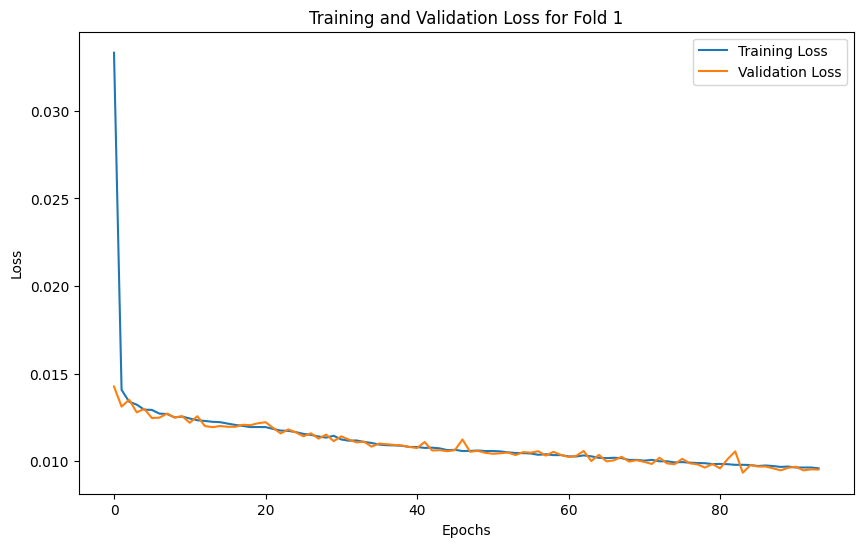

786/786 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Results for Housing:
Train Data: MAE: 84.0195, R-Squared: 0.8989, RMSE: 122.7827, MSE: 15075.5874 ,SMAPE: 7.790124948056643, MAPE: 7.7402
Validation Data: MAE: 83.4545, R-Squared: 0.8975, RMSE: 120.7878, MSE: 14589.6908 ,SMAPE: 7.8004515428199195, MAPE: 7.7715
Test Data: MAE: 85.2798, R-Squared: 0.8964, RMSE: 123.7053, MSE: 15303.0004 ,SMAPE: 7.911255672689585, MAPE: 7.8838

Model Results for Food:
Train Data: MAE: 43.0808, R-Squared: 0.9654, RMSE: 63.5278, MSE: 4035.7837 ,SMAPE: 4.95041728996757, MAPE: 4.9382
Validation Data: MAE: 41.7039, R-Squared: 0.9693, RMSE: 59.2397, MSE: 3509.3457 ,SMAPE: 4.855043968035324, MAPE: 4.8532
Test Data: MAE: 44.2447, R-Squared: 0.9596, RMSE: 68.8572, MSE: 4741.3136 ,SMAPE: 5.030118133959188, MAPE: 5.0063

Model Results for Transportation:
Train Data: MAE: 95.3672, R-Squared: 0.7087, RMSE: 128.0111, MSE: 16386.8508 ,SMAPE: 6.215

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 11, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 11, 8)          │             32 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 88)             │              0 │ conv1d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 128)            │         11,392 │ flatten_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 64)             │          8,256 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_housing (Dense)    │ (None, 1)              │             65 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_food (Dense)       │ (None, 1)              │             65 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_transportation     │ (None, 1)              │             65 │ dense_29[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_healthcare (Dense) │ (None, 1)              │             65 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_othernecessities   │ (None, 1)              │             65 │ dense_29[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_childcare (Dense)  │ (None, 1)              │             65 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_taxes (Dense)      │ (None, 1)              │             65 │ dense_29[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,135 (78.65 KB)

 Trainable params: 20,135 (78.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0836 - target_childcare_loss: 0.0133 - target_food_loss: 0.0055 - target_healthcare_loss: 0.0208 - target_housing_loss: 0.0051 - target_othernecessities_loss: 0.0081 - target_taxes_loss: 0.0062 - target_transportation_loss: 0.0247 - val_loss: 0.0144 - val_target_childcare_loss: 0.0021 - val_target_food_loss: 5.4703e-04 - val_target_healthcare_loss: 0.0052 - val_target_housing_loss: 0.0015 - val_target_othernecessities_loss: 0.0010 - val_target_taxes_loss: 6.3995e-04 - val_target_transportation_loss: 0.0036
Epoch 2/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0139 - target_childcare_loss: 0.0021 - target_food_loss: 6.0659e-04 - target_healthcare_loss: 0.0049 - target_housing_loss: 0.0014 - target_othernecessities_loss: 8.9035e-04 - target_taxes_loss: 5.5064e-04 - target_transportation_loss: 0.0035 - val_loss: 0.0144 - val_target_childcare_loss: 0.0023 - val_target_food_loss: 5.2205e-04 - val_target_healthcare_los

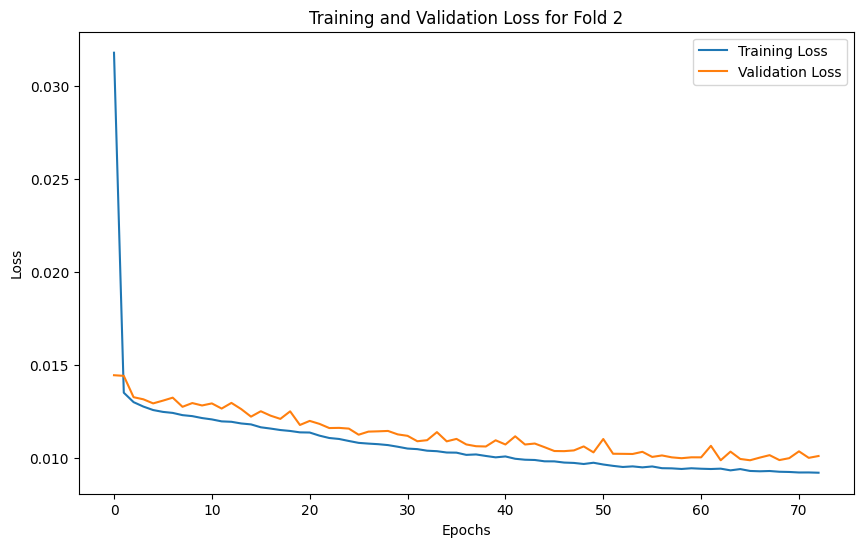

786/786 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Results for Housing:
Train Data: MAE: 80.8993, R-Squared: 0.9045, RMSE: 117.272, MSE: 13752.7229 ,SMAPE: 7.538849990243704, MAPE: 7.5906
Validation Data: MAE: 83.1539, R-Squared: 0.9075, RMSE: 123.5259, MSE: 15258.6462 ,SMAPE: 7.632758891380077, MAPE: 7.6902
Test Data: MAE: 83.501, R-Squared: 0.9072, RMSE: 123.9986, MSE: 15375.6447 ,SMAPE: 7.598806657392982, MAPE: 7.6155

Model Results for Food:
Train Data: MAE: 43.2497, R-Squared: 0.9652, RMSE: 63.4892, MSE: 4030.8824 ,SMAPE: 4.96444446893831, MAPE: 4.9713
Validation Data: MAE: 42.5919, R-Squared: 0.9693, RMSE: 61.0945, MSE: 3732.5434 ,SMAPE: 4.890632891461749, MAPE: 4.9015
Test Data: MAE: 43.8594, R-Squared: 0.9651, RMSE: 63.7702, MSE: 4066.6351 ,SMAPE: 5.020844424802283, MAPE: 5.0259

Model Results for Transportation:
Train Data: MAE: 95.1579, R-Squared: 0.7179, RMSE: 126.1238, MSE: 15907.2135 ,SMAPE: 6.190590

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 11, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 11, 8)          │             32 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 88)             │              0 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 128)            │         11,392 │ flatten_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 64)             │          8,256 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_housing (Dense)    │ (None, 1)              │             65 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_food (Dense)       │ (None, 1)              │             65 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_transportation     │ (None, 1)              │             65 │ dense_31[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_healthcare (Dense) │ (None, 1)              │             65 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_othernecessities   │ (None, 1)              │             65 │ dense_31[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_childcare (Dense)  │ (None, 1)              │             65 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_taxes (Dense)      │ (None, 1)              │             65 │ dense_31[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,135 (78.65 KB)

 Trainable params: 20,135 (78.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0614 - target_childcare_loss: 0.0078 - target_food_loss: 0.0102 - target_healthcare_loss: 0.0102 - target_housing_loss: 0.0038 - target_othernecessities_loss: 0.0105 - target_taxes_loss: 0.0035 - target_transportation_loss: 0.0154 - val_loss: 0.0151 - val_target_childcare_loss: 0.0024 - val_target_food_loss: 7.2173e-04 - val_target_healthcare_loss: 0.0053 - val_target_housing_loss: 0.0015 - val_target_othernecessities_loss: 0.0013 - val_target_taxes_loss: 4.8021e-04 - val_target_transportation_loss: 0.0035
Epoch 2/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0138 - target_childcare_loss: 0.0022 - target_food_loss: 6.0534e-04 - target_healthcare_loss: 0.0049 - target_housing_loss: 0.0014 - target_othernecessities_loss: 9.5115e-04 - target_taxes_loss: 4.8687e-04 - target_transportation_loss: 0.0034 - val_loss: 0.0138 - val_target_childcare_loss: 0.0021 - val_target_food_loss: 6.3774e-04 - val_target_healthcare_loss:

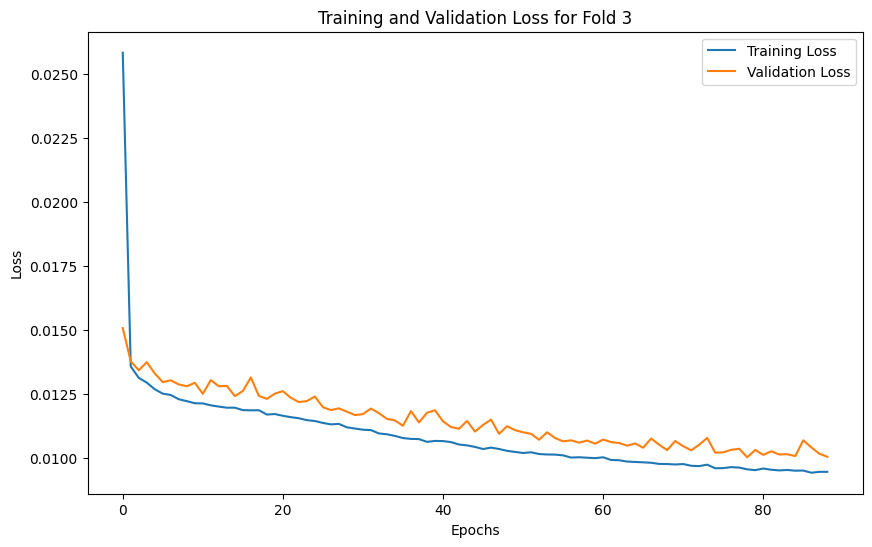

786/786 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Results for Housing:
Train Data: MAE: 82.1666, R-Squared: 0.9044, RMSE: 119.467, MSE: 14272.3736 ,SMAPE: 7.646925119010219, MAPE: 7.708
Validation Data: MAE: 85.1, R-Squared: 0.8948, RMSE: 122.7592, MSE: 15069.8219 ,SMAPE: 7.927627396345054, MAPE: 8.0239
Test Data: MAE: 82.1656, R-Squared: 0.899, RMSE: 121.228, MSE: 14696.2186 ,SMAPE: 7.600478218429714, MAPE: 7.6891

Model Results for Food:
Train Data: MAE: 43.4053, R-Squared: 0.9655, RMSE: 63.432, MSE: 4023.6151 ,SMAPE: 4.979896117823653, MAPE: 4.9743
Validation Data: MAE: 45.4224, R-Squared: 0.9607, RMSE: 68.1048, MSE: 4638.2635 ,SMAPE: 5.155993388734609, MAPE: 5.135
Test Data: MAE: 43.5724, R-Squared: 0.9627, RMSE: 64.7558, MSE: 4193.3129 ,SMAPE: 4.9794177549437695, MAPE: 4.979

Model Results for Transportation:
Train Data: MAE: 94.82, R-Squared: 0.7102, RMSE: 128.2536, MSE: 16448.9771 ,SMAPE: 6.17895699844995

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 11, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 11, 8)          │             32 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 88)             │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 128)            │         11,392 │ flatten_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 64)             │          8,256 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_housing (Dense)    │ (None, 1)              │             65 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_food (Dense)       │ (None, 1)              │             65 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_transportation     │ (None, 1)              │             65 │ dense_33[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_healthcare (Dense) │ (None, 1)              │             65 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_othernecessities   │ (None, 1)              │             65 │ dense_33[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_childcare (Dense)  │ (None, 1)              │             65 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_taxes (Dense)      │ (None, 1)              │             65 │ dense_33[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,135 (78.65 KB)

 Trainable params: 20,135 (78.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0653 - target_childcare_loss: 0.0050 - target_food_loss: 0.0027 - target_healthcare_loss: 0.0179 - target_housing_loss: 0.0052 - target_othernecessities_loss: 0.0039 - target_taxes_loss: 0.0047 - target_transportation_loss: 0.0260 - val_loss: 0.0133 - val_target_childcare_loss: 0.0020 - val_target_food_loss: 5.4453e-04 - val_target_healthcare_loss: 0.0049 - val_target_housing_loss: 0.0013 - val_target_othernecessities_loss: 8.5580e-04 - val_target_taxes_loss: 5.0383e-04 - val_target_transportation_loss: 0.0032
Epoch 2/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0141 - target_childcare_loss: 0.0021 - target_food_loss: 6.9598e-04 - target_healthcare_loss: 0.0049 - target_housing_loss: 0.0014 - target_othernecessities_loss: 9.6450e-04 - target_taxes_loss: 5.1099e-04 - target_transportation_loss: 0.0034 - val_loss: 0.0126 - val_target_childcare_loss: 0.0019 - val_target_food_loss: 5.3900e-04 - val_target_healthcare_l

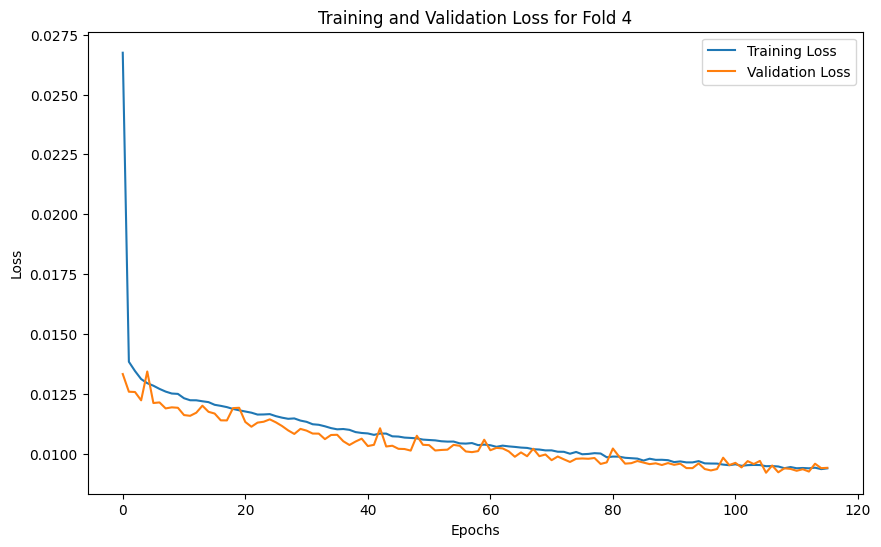

786/786 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Results for Housing:
Train Data: MAE: 81.964, R-Squared: 0.9045, RMSE: 119.352, MSE: 14244.906 ,SMAPE: 7.5987273354240745, MAPE: 7.5908
Validation Data: MAE: 82.3258, R-Squared: 0.8932, RMSE: 120.3212, MSE: 14477.1971 ,SMAPE: 7.708534592755948, MAPE: 7.6624
Test Data: MAE: 85.0774, R-Squared: 0.8982, RMSE: 125.1281, MSE: 15657.0503 ,SMAPE: 7.804432953041954, MAPE: 7.773

Model Results for Food:
Train Data: MAE: 43.9432, R-Squared: 0.9644, RMSE: 64.4385, MSE: 4152.3245 ,SMAPE: 5.003766963761716, MAPE: 5.0311
Validation Data: MAE: 43.2556, R-Squared: 0.9677, RMSE: 61.2759, MSE: 3754.7345 ,SMAPE: 5.023488271459643, MAPE: 5.0685
Test Data: MAE: 43.6759, R-Squared: 0.9664, RMSE: 62.4511, MSE: 3900.1451 ,SMAPE: 4.950250147261759, MAPE: 4.99

Model Results for Transportation:
Train Data: MAE: 95.1157, R-Squared: 0.7112, RMSE: 127.807, MSE: 16334.6283 ,SMAPE: 6.183356747

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 11, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 11, 8)          │             32 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 88)             │              0 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 128)            │         11,392 │ flatten_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 64)             │          8,256 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_housing (Dense)    │ (None, 1)              │             65 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_food (Dense)       │ (None, 1)              │             65 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_transportation     │ (None, 1)              │             65 │ dense_35[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_healthcare (Dense) │ (None, 1)              │             65 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_othernecessities   │ (None, 1)              │             65 │ dense_35[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_childcare (Dense)  │ (None, 1)              │             65 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_taxes (Dense)      │ (None, 1)              │             65 │ dense_35[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,135 (78.65 KB)

 Trainable params: 20,135 (78.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0831 - target_childcare_loss: 0.0060 - target_food_loss: 0.0075 - target_healthcare_loss: 0.0231 - target_housing_loss: 0.0113 - target_othernecessities_loss: 0.0081 - target_taxes_loss: 0.0089 - target_transportation_loss: 0.0183 - val_loss: 0.0133 - val_target_childcare_loss: 0.0019 - val_target_food_loss: 6.7054e-04 - val_target_healthcare_loss: 0.0049 - val_target_housing_loss: 0.0014 - val_target_othernecessities_loss: 8.9707e-04 - val_target_taxes_loss: 4.6149e-04 - val_target_transportation_loss: 0.0031
Epoch 2/200
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0137 - target_childcare_loss: 0.0021 - target_food_loss: 5.9330e-04 - target_healthcare_loss: 0.0049 - target_housing_loss: 0.0014 - target_othernecessities_loss: 9.1092e-04 - target_taxes_loss: 4.6374e-04 - target_transportation_loss: 0.0034 - val_loss: 0.0130 - val_target_childcare_loss: 0.0019 - val_target_food_loss: 6.5949e-04 - val_target_healthcare_l

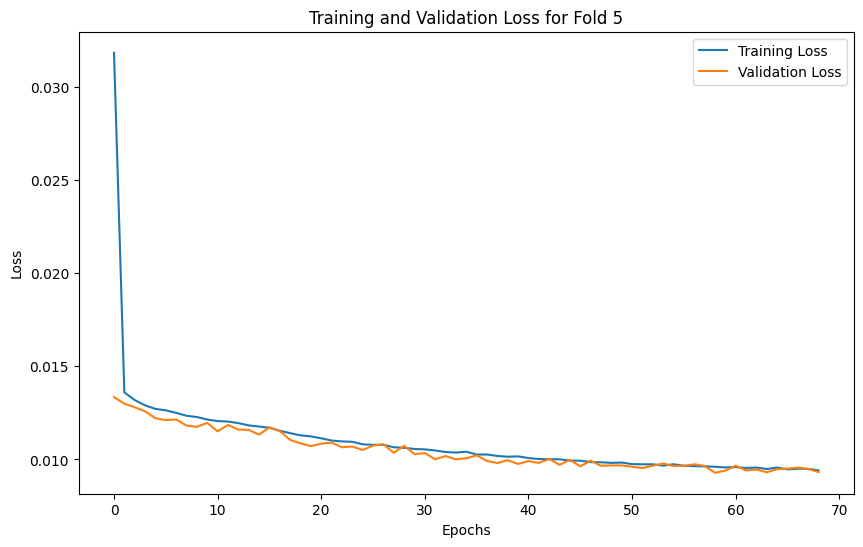

786/786 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Results for Housing:
Train Data: MAE: 83.644, R-Squared: 0.9034, RMSE: 120.3175, MSE: 14476.3121 ,SMAPE: 7.8024233876394815, MAPE: 7.9241
Validation Data: MAE: 84.5366, R-Squared: 0.8906, RMSE: 120.2786, MSE: 14466.95 ,SMAPE: 7.819085770139345, MAPE: 7.9321
Test Data: MAE: 84.5763, R-Squared: 0.9018, RMSE: 121.9718, MSE: 14877.1137 ,SMAPE: 7.879785158767344, MAPE: 8.0244

Model Results for Food:
Train Data: MAE: 43.0009, R-Squared: 0.9648, RMSE: 64.0294, MSE: 4099.7643 ,SMAPE: 4.948100185494896, MAPE: 4.8666
Validation Data: MAE: 45.9452, R-Squared: 0.9567, RMSE: 71.0107, MSE: 5042.5218 ,SMAPE: 5.2260483857121995, MAPE: 5.1331
Test Data: MAE: 44.0115, R-Squared: 0.9638, RMSE: 64.8007, MSE: 4199.1323 ,SMAPE: 5.1042611219905565, MAPE: 5.0101

Model Results for Transportation:
Train Data: MAE: 95.5445, R-Squared: 0.7085, RMSE: 128.512, MSE: 16515.3239 ,SMAPE: 6.2255

In [46]:
# Cross-Validation with Evaluation
def cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, num_epochs=200):# 200 iterations
    global X_train_global, X_test_global, X_val_global
    global y_train_global, y_test_global, y_val_global
    fold = 1
    for train_index, val_index in kf.split(X_scaled):
        print(f"Fold {fold}/{kf.get_n_splits()}")
        X_train, X_test_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_test_val = y_exp_scaled[train_index], y_exp_scaled[val_index] # 80% training

        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=100) # 50/50 split of remaining 20% for testing and validation

        X_train_global, X_test_global, X_val_global = X_train, X_test, X_val
        y_train_global, y_test_global, y_val_global = y_train, y_test, y_val

        # Reshaping data for CNN
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        household_model = create_hybrid_model((X_train.shape[1], 1), y_train.shape[1])
        household_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') # adams optimizer is used

        household_model.summary()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # early stopping to avoid excess training/overfitting

        # Training
        history=household_model.fit(X_train, [y_train[:, i] for i in range(y_train.shape[1])],
                  validation_data=(X_val, [y_val[:, i] for i in range(y_val.shape[1])]),
                  epochs=num_epochs, batch_size=64, verbose=1, callbacks= [early_stopping])
           # Plot training and validation loss curves for all the 5 folds
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss for Fold {fold}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Predictions
        y_train_pred = np.column_stack(household_model.predict(X_train)) #. Prediction on the train set
        y_val_pred = np.column_stack(household_model.predict(X_val))# Prediction on the validation set
        y_test_pred = np.column_stack(household_model.predict(X_test)) #Prediction on test set

        # Inverse scaling
        y_train_pred_original = scaler_y.inverse_transform(y_train_pred)
        y_train_original = scaler_y.inverse_transform(y_train)
        y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
        y_val_original = scaler_y.inverse_transform(y_val)
        y_test_pred_original = scaler_y.inverse_transform(y_test_pred) #Inverse transform for test set
        y_test_original = scaler_y.inverse_transform(y_test) #Inverse transform for test set

        # Enforce the rule after predictions for childcare expense
        # The issue is likely caused by X_train having an extra dimension due to[..., np.newaxis].
        # We need to select the original features for the condition
        y_train_pred_original[:, childcare_exp_col] = np.where(
            X_train[:, num_children_col, 0] == 0, 0, y_train_pred_original[:, childcare_exp_col]) #Using X_train[:, num_children_col, 0] instead of X_train[:, num_children_col]

        y_val_pred_original[:, childcare_exp_col] = np.where(
            X_val[:, num_children_col, 0] == 0, 0, y_val_pred_original[:, childcare_exp_col]) #Using X_val[:, num_children_col, 0] instead of X_val[:, num_children_col]

        y_test_pred_original[:, childcare_exp_col] = np.where(
            X_test[:, num_children_col, 0] == 0, 0, y_test_pred_original[:, childcare_exp_col]) #Using X_test[:, num_children_col, 0] instead of X_test[:, num_children_col]

        # Metrics for each target
        for i, target in enumerate(target_col_list):
            print(f'Model Results for {target.capitalize()}:')
            print('Train Data:', regr_report(y_train_original[:, i], y_train_pred_original[:, i]))#Print metric for train set
            print('Validation Data:', regr_report(y_val_original[:, i], y_val_pred_original[:, i])) #Print metrics for validation set
            print('Test Data:', regr_report(y_test_original[:, i], y_test_pred_original[:, i])) #Print metrics for test set
            print()

        fold += 1 # moving to the next k fold (iteration process)
    return household_model

household_model_combine = cross_val_with_evaluation(X_scaled, y_exp_scaled,kf) # passing the parameters such as the scaled features, targets, and the number of k folds

In [ ]:
'''# Cross-Validation with Evaluation for XGBoost
def cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, num_boost_rounds=4000):
    fold = 1
    childcarelist = []
    childcarelist_pred = []
    for train_index, val_index in kf.split(X_scaled):
        models = []
        print(f"Fold {fold}/{kf.get_n_splits()}")
        X_train, X_test_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_test_val = y_exp_scaled[train_index], y_exp_scaled[val_index]

        # Split validation and test data
        X_test, X_val, y_test, y_val = train_test_split(
            X_test_val, y_test_val, test_size=0.5, random_state=100
        )  # 50/50 split of remaining 20%

        # Train XGBoost model for each target variable
        # Store predictions for all targets in this fold
        all_y_train_pred = []
        all_y_val_pred = []
        all_y_test_pred = []

        for i in range(y_train.shape[1]):
            dtrain = xgb.DMatrix(X_train, label=y_train[:, i])
            dval = xgb.DMatrix(X_val, label=y_val[:, i])
            dtest = xgb.DMatrix(X_test)

            params = {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'learning_rate': 0.01,
                'max_depth': 6,
                'n_estimators': num_boost_rounds
            }

            evals = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(
                params, dtrain, num_boost_rounds, evals, early_stopping_rounds=50, verbose_eval=50
            )
            models.append(model) #Not required here

            # Predictions
            y_train_pred = model.predict(dtrain)
            y_val_pred = model.predict(dval)
            y_test_pred = model.predict(dtest)

            # Append predictions for current target to the list
            all_y_train_pred.append(y_train_pred)
            all_y_val_pred.append(y_val_pred)
            all_y_test_pred.append(y_test_pred)

        # Stack predictions for all targets to get the original shape
        y_train_pred = np.column_stack(all_y_train_pred)
        y_val_pred = np.column_stack(all_y_val_pred)
        y_test_pred = np.column_stack(all_y_test_pred)

        # Inverse scaling
        y_train_pred_original = scaler_y.inverse_transform(y_train_pred) #Now y_train_pred has 7 columns matching scaler_y
        y_train_original = scaler_y.inverse_transform(y_train)
        y_val_pred_original = scaler_y.inverse_transform(y_val_pred)  #Now y_val_pred has 7 columns matching scaler_y
        y_val_original = scaler_y.inverse_transform(y_val)
        y_test_pred_original = scaler_y.inverse_transform(y_test_pred) #Now y_test_pred has 7 columns matching scaler_y
        y_test_original = scaler_y.inverse_transform(y_test)


        # Enforce the rule after predictions for childcare expense
        y_train_pred_original[:, childcare_exp_col] = np.where(
            X_train[:, num_children_col] == 0, 0, y_train_pred_original[:, childcare_exp_col])

        y_val_pred_original[:, childcare_exp_col] = np.where(
            X_val[:, num_children_col] == 0, 0, y_val_pred_original[:, childcare_exp_col])

        y_test_pred_original[:, childcare_exp_col] = np.where(
            X_test[:, num_children_col] == 0, 0, y_test_pred_original[:, childcare_exp_col])

        # Metrics for each target
        for i, target in enumerate(target_col_list):
            print(f'Model Results for {target.capitalize()}:')
            print('Train Data:', regr_report(y_train_original[:, i], y_train_pred_original[:, i]))
            print('Validation Data:', regr_report(y_val_original[:, i], y_val_pred_original[:, i]))
            print('Test Data:', regr_report(y_test_original[:, i], y_test_pred_original[:, i])) #Print metrics for test set
            print()

        fold += 1
    return models

# Cross-Validation Execution
xgb_models = cross_val_with_evaluation(X_scaled, y_exp_scaled, kf)'''

In [ ]:
'''def createAdditinalFeatures(X_scaled, xgb_models):
  #initialize a list to store the predicitions
    new_y_exp_scaled = []
    # Iterate over the model and generate the prediction
    for model in tqdm(xgb_models):
        predict_vals = model.predict(xgb.DMatrix(X_scaled))
        new_y_exp_scaled.append(predict_vals)

    new_y_exp_scaled_val = np.array(new_y_exp_scaled) # convert the prediction into a numpy array
    new_y_exp_scaled_val_transp = new_y_exp_scaled_val.T # transposing the predictions to make them concatenate with the original values
    a = X_scaled
    b = new_y_exp_scaled_val_transp
    results = []
    for f,t in zip(a,b):
        results.append(list(f)+list(t))

    additional_features =  np.array(results)
    return additional_features'''

In [ ]:
#additional_features = createAdditinalFeatures(X_scaled, xgb_models)

In [ ]:
'''# Cross-Validation with Evaluation
def cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, num_epochs=200):
    fold = 1
    for train_index, val_index in kf.split(X_scaled):
        print(f"Fold {fold}/{kf.get_n_splits()}")
        X_train, X_test_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_test_val = y_exp_scaled[train_index], y_exp_scaled[val_index]

        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=100) # 50/50 split of remaining 20%

        # Reshaping data for CNN
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        model = create_hybrid_model((X_train.shape[1], 1), y_train.shape[1])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.summary()

        # Training
        model.fit(X_train, [y_train[:, i] for i in range(y_train.shape[1])],
                  validation_data=(X_val, [y_val[:, i] for i in range(y_val.shape[1])]),
                  epochs=num_epochs, batch_size=64, verbose=1, callbacks=[early_stopping])

        # Predictions
        y_train_pred = np.column_stack(model.predict(X_train))
        y_val_pred = np.column_stack(model.predict(X_val))
        y_test_pred = np.column_stack(model.predict(X_test)) #Prediction on test set

        # Inverse scaling
        y_train_pred_original = scaler_y.inverse_transform(y_train_pred)
        y_train_original = scaler_y.inverse_transform(y_train)
        y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
        y_val_original = scaler_y.inverse_transform(y_val)
        y_test_pred_original = scaler_y.inverse_transform(y_test_pred) #Inverse transform for test set
        y_test_original = scaler_y.inverse_transform(y_test) #Inverse transform for test set

        # Enforce the rule after predictions for childcare expense
        # The issue is likely caused by X_train having an extra dimension due to[..., np.newaxis].
        # We need to select the original features for the condition
        y_train_pred_original[:, childcare_exp_col] = np.where(
            X_train[:, num_children_col, 0] == 0, 0, y_train_pred_original[:, childcare_exp_col]) #Using X_train[:, num_children_col, 0] instead of X_train[:, num_children_col]

        y_val_pred_original[:, childcare_exp_col] = np.where(
            X_val[:, num_children_col, 0] == 0, 0, y_val_pred_original[:, childcare_exp_col]) #Using X_val[:, num_children_col, 0] instead of X_val[:, num_children_col]

        y_test_pred_original[:, childcare_exp_col] = np.where(
            X_test[:, num_children_col, 0] == 0, 0, y_test_pred_original[:, childcare_exp_col]) #Using X_test[:, num_children_col, 0] instead of X_test[:, num_children_col]

        # Metrics for each target
        for i, target in enumerate(target_col_list):
            print(f'Model Results for {target.capitalize()}:')
            print('Train Data:', regr_report(y_train_original[:, i], y_train_pred_original[:, i]))
            print('Validation Data:', regr_report(y_val_original[:, i], y_val_pred_original[:, i]))
            print('Test Data:', regr_report(y_test_original[:, i], y_test_pred_original[:, i])) #Print metrics for test set
            print()

        fold += 1
        return model # Return the trained model
model_combine = cross_val_with_evaluation(additional_features, y_exp_scaled, kf)
model_combine.save_weights("model_expenses.weights.h5")'''

In [ ]:

'''
# Load the scalers
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

def get_prediction(model_combine, input_data, scaler_X, scaler_y, num_children_col, childcare_exp_col):
    """
    Generates predictions for expenses using the combined model.

    Args:
        model_combine: The trained Keras model.
        input_data: Pandas DataFrame of new input data.
        scaler_X: Fitted MinMaxScaler for features.
        scaler_y: Fitted MinMaxScaler for target variables.
        num_children_col: Integer column index for number of children.
        childcare_exp_col: Integer column index for the 'childcare' target.

    Returns:
         Numpy Array: Predicted expense values.
    """

    # Step 1: Create new features
    input_data_with_features = createFeatures(input_data.copy())

    # Step 2: Select relevant features
    X = input_data_with_features[['total', 'median_family_income', 'num_counties_in_st', 'n_children',
                                  'n_parents', 'n_members', 'per_member_cost', 'child_expense_cost',
                                  'parent_expense_cost', 'other_expense_cost','zero_childcare_cost']].values

    # Step 3: Scale the input data using the fitted scaler_X
    input_data_scaled = scaler_X.transform(X)

    # Step 4: Reshape for the CNN layer (add the extra dimension)
    input_data_scaled = input_data_scaled[..., np.newaxis]  # This line is crucial to match the training data shape

    # Step 5: Make predictions using the trained model
    # We need to unpack the predictions from the model output
    # Then, we can stack those into a single output array.
    input_data_pred = model_combine.predict(input_data_scaled)
    input_data_pred = np.column_stack(input_data_pred)

    # Step 6: Inverse transform the predictions to return them to the original scale
    input_data_pred_original = scaler_y.inverse_transform(input_data_pred)

    # Step 7: Enforce the rule that if there are no children, childcare cost is 0
    input_data_pred_original[:, childcare_exp_col] = np.where(
        input_data_with_features['n_children'].values == 0, 0, input_data_pred_original[:, childcare_exp_col]
    )

    return input_data_pred_original

def createFeatures(input_data):
    """
    Creates additional features needed for the model prediction.

    Args:
        input_data: The input pandas DataFrame with the original data.

    Returns:
        input_data: The input data with additional features.
    """
    # Step 1: Create additional features
    input_data["per_member_cost"] = input_data["total"] / input_data["n_members"]
    input_data["child_expense_cost"] = input_data["per_member_cost"] * input_data["n_children"]
    input_data["parent_expense_cost"] = input_data["per_member_cost"] * input_data["n_parents"]
    input_data["other_expense_cost"] = input_data["total"] - (input_data["child_expense_cost"] + input_data["parent_expense_cost"])

    # Step 2: Create binary column for whether there are children (0 if no children, 1 if there are children)
    input_data["zero_childcare_cost"] = input_data['n_children'].map(lambda x: 0 if x < 1 else 1)

    return input_data

# Example of input data to test predictions
input_data = pd.DataFrame(
    [[4541, 8790.0, 67, 0, 2, 2]],
    columns=['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']
)

# Assuming `model_combine` is your trained model
input_data_pred_original = get_prediction(model_combine, input_data, scaler_X, scaler_y, num_children_col=3, childcare_exp_col=5)

# Print predictions
target_col_list = ['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']
for i, prediction in enumerate(input_data_pred_original[0]):
    print(f"{target_col_list[i]}: {prediction:.2f}")'''
